In [1]:
import sys
sys.path.append("../")

In [2]:
from typing import Tuple, Dict, List
from collections import defaultdict
from ds4400_final_project.dataset.common import train_and_evaluate_classifier, print_classifier_results, get_best_test_result
from ds4400_final_project.dataset.common_plotting import plot_param_comparison_per_dataset
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# list of all kernels to try
kernels = ["linear", "poly", "rbf", "sigmoid"]
# list of all datasets to try
csv_files = ["features_3_sec.csv", "features_30_sec.csv"]

# { CSV_FILENAME: { SOLVER: ( TRAIN_ACC, TEST_ACC, FAILED_COUNT ) }
results: Dict[str, Dict[str, Tuple]] = defaultdict(dict)

# iterate over all solvers
for kernel in kernels:
	# iterate over all datasets
	for filename in csv_files:
		# construct the model
		classifier = SVC(kernel=kernel)

		# train and evaluate the model
		train_acc, test_acc, failed_count = train_and_evaluate_classifier(filename, classifier)
		results[filename][kernel] = (train_acc, test_acc, failed_count)

In [4]:
# print all results from all models
for filename, result in results.items():
	for kernel, (train_acc, test_acc, failed_count) in result.items():
		print_classifier_results(f"{filename} ({kernel})", train_acc, test_acc, failed_count)

Features 3 Sec
Train accuracy: 81.02%
Train error:    18.98%
Test accuracy:  76.28%
Test error:     23.72%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | ROCK       | 418            | 20.4%              |
| 02  | REGGAE     | 310            | 15.1%              |
| 03  | COUNTRY    | 272            | 13.3%              |
| 04  | DISCO      | 267            | 13.0%              |
| 05  | HIPHOP     | 241            | 11.7%              |
| 06  | BLUES      | 153            | 7.5%               |
| 07  | POP        | 136            | 6.6%               |
| 08  | JAZZ       | 121            | 5.9%               |
| 09  | METAL      | 101            | 4.9%               |
| 10  | CLASSICAL  | 33             | 1.6%               |
Features 3 Sec
Train accuracy: 87.09%
Train error:    12.91%
Test accuracy:  79.92%
Test error:     20.08%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---   

In [5]:
# print the results from the model with the best test accuracy
filename, kernel, (train_acc, test_acc, failed_count) = get_best_test_result(results)
print_classifier_results(f"Best Test Result: {filename} ({kernel})", train_acc, test_acc, failed_count)

Best Test Result: Features 3 Sec
Train accuracy: 91.18%
Train error:    8.82%
Test accuracy:  85.2%
Test error:     14.8%

| #   | Genre      | # of Incorrect | % of All Incorrect |
| --- |    ---     |      ---       |        ---         |
| 01  | ROCK       | 224            | 20.8%              |
| 02  | DISCO      | 137            | 12.7%              |
| 03  | COUNTRY    | 133            | 12.3%              |
| 04  | HIPHOP     | 127            | 11.8%              |
| 05  | REGGAE     | 108            | 10.0%              |
| 06  | BLUES      | 95             | 8.8%               |
| 07  | POP        | 88             | 8.2%               |
| 08  | JAZZ       | 82             | 7.6%               |
| 09  | METAL      | 66             | 6.1%               |
| 10  | CLASSICAL  | 18             | 1.7%               |


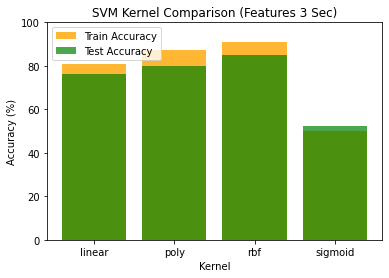

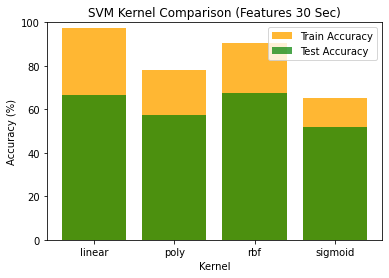

In [16]:
plot_param_comparison_per_dataset("SVM Kernel Comparison", "Kernel", results)